In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [8]:
df = pd.read_csv('r490.csv')
df = df[df['r1_charge_heater'] >= 0]

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])


traces/r490/noiseless_hard_random.json
(50, 101)
traces/r490/noiseless_hard_greedy.json
(50, 101)
traces/r490/noiseless_hard_eg.json
(50, 101)
traces/r490/noiseless_hard_pi.json
(50, 101)
traces/r490/noiseless_hard_ei.json
(50, 101)


/tmp/ipykernel_2378594/3718632272.py:64: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(trace_chs, axis=0)
/home/mmkhajah/venvs/sci/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2378594/3718632272.py:64: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(trace_chs, axis=0)
/home/mmkhajah/venvs/sci/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmkhajah/venvs/sci/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2378594/3718632272.py:64: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(trace_chs, axis=0)
/home/mmkhajah/venvs/sci/lib/python3.8/s

Text(0.5, 1.03, 'Active Experimentation')

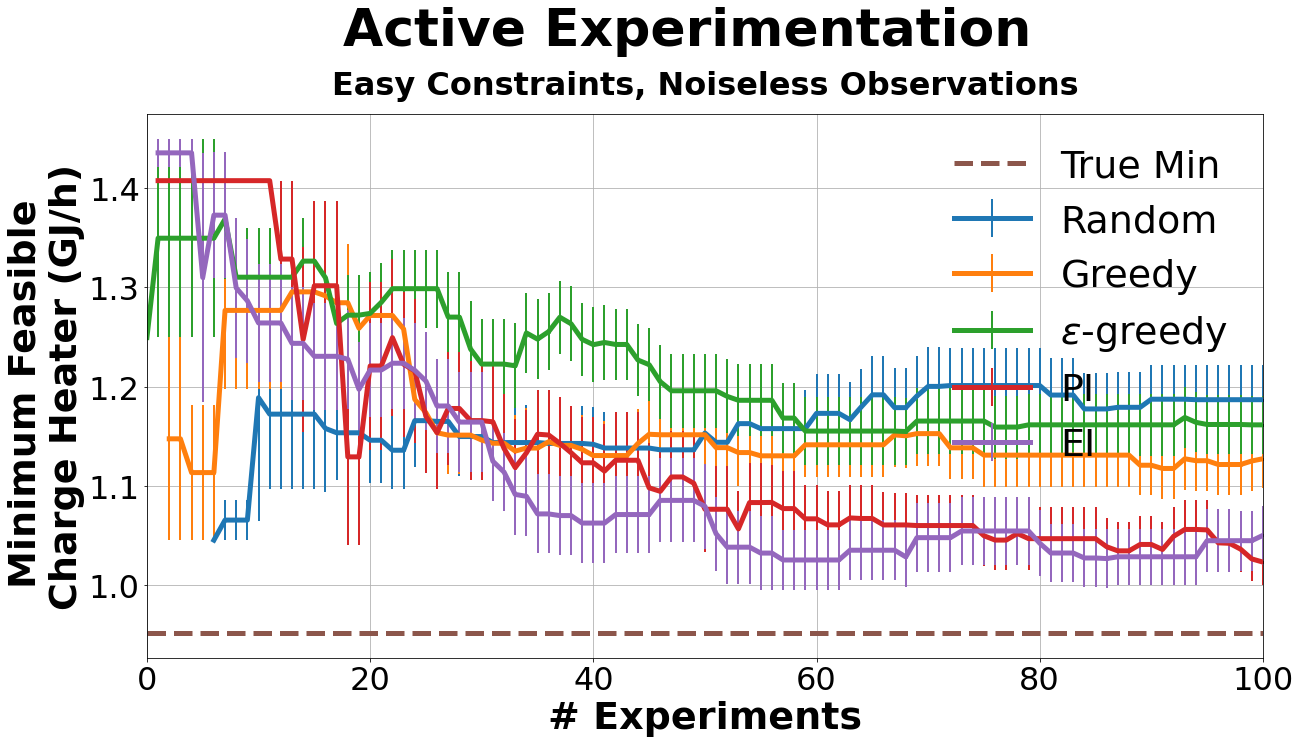

In [19]:
exp = 'noiseless_hard'
output_path = 'tmp/fig10.tiff'
title = "Easy Constraints, Noiseless Observations"

# exp = 'noisy_83_99'
# output_path = 'tmp/fig14.tiff'
# title = "Difficult Constraints, Noisy Observations"

# exp = 'noisy_83_99_constrained'
# output_path = 'tmp/fig15.tiff'
# title = "Difficult Constraints, Noisy Observations, Restricted Transitions"



with open("exp_cfgs/%s.json" % exp, 'r') as f:
    exp_cfg = json.load(f)

min_ron = exp_cfg['min_ron']
min_yield = exp_cfg['min_yield']
models = ['random',  'greedy', 'eg', 'pi', 'ei']
names = ['Random',  'Greedy', '$\epsilon$-greedy', 'PI', 'EI']
#models = ['random']
paths = [(m, "traces/r490/%s_%s.json" % (exp, m), n) for m,n in zip(models, names)]

# we have to take into account the expected value of the min yield 
# in noisy experiments. Since the noise is added symmetricly around those thresholds this is usually the
# same as the threshold itself. But for example when yield is 99 and delta is 2.5, the 
# expected value is 98.25, which makes a huge difference.
if exp_cfg['yield_delta'] > 0:
    yield_upper = np.minimum(100, min_yield + exp_cfg['yield_delta'])
    yield_lower = min_yield - exp_cfg['yield_delta']
    min_yield = (yield_upper + yield_lower) / 2
    print("Effective min yield: %0.2f" % min_yield)
    
# if exp_cfg['ron_delta'] > 0:
#     ron_upper = np.maximum(100, min_ron + exp_cfg['ron_delta'])
#     ron_lower = min_yield - exp_cfg['yield_delta']
#     min_yield = (yield_upper + yield_lower) / 2

valid_comb_ix =(df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for _,p,name in paths:
    print(p)
    with open(p, 'r') as f:
        results = json.load(f)

    trace_chs = []
    for obs_traces, traces in zip(results['obs_traces'], results['traces']):
        true_traces = Y[traces, :]
        obs_traces = np.array(obs_traces)
        
        fix = (true_traces[:,1] >= min_ron) & (true_traces[:,2] >= min_yield)
        obs_traces[~fix,0] = np.inf
        trace_chs.append(np.minimum.accumulate(obs_traces[:,0]))
    
    #inputs = df.iloc[results['traces'][0]]
    #print(inputs.iloc[10:])
    trace_chs = np.array(trace_chs) / (1000*1000)
    print(trace_chs.shape)
    trace_chs[np.isinf(trace_chs)] = np.nan
    reps = np.sum(~np.isnan(trace_chs), axis=0)
    
    mean_trace = np.nanmean(trace_chs, axis=0)
    stderr_trace = np.nanstd(trace_chs, axis=0, ddof=1) / np.sqrt(reps)
    
    ax.errorbar(np.arange(mean_trace.shape[0]), mean_trace, yerr=stderr_trace, linewidth=5, label=name, marker='o', markersize=2, elinewidth=2)
    #ax.plot(, )

ax.plot(np.arange(mean_trace.shape[0]), np.ones(mean_trace.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater'] / (1000*1000)), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('# Experiments', fontsize=38, fontweight='bold')
ax.set_ylabel('Minimum Feasible \nCharge Heater (GJ/h)', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_title(title, fontsize=32, fontweight='bold', pad=20)

ax.legend(fontsize=38, frameon=False)
ax.set_xlim([0,100])

plt.suptitle('Active Experimentation', fontsize=52, fontweight='bold', y=1.03)
#plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


FileNotFoundError: [Errno 2] No such file or directory: 'traces/noiseless_easy_random.json'

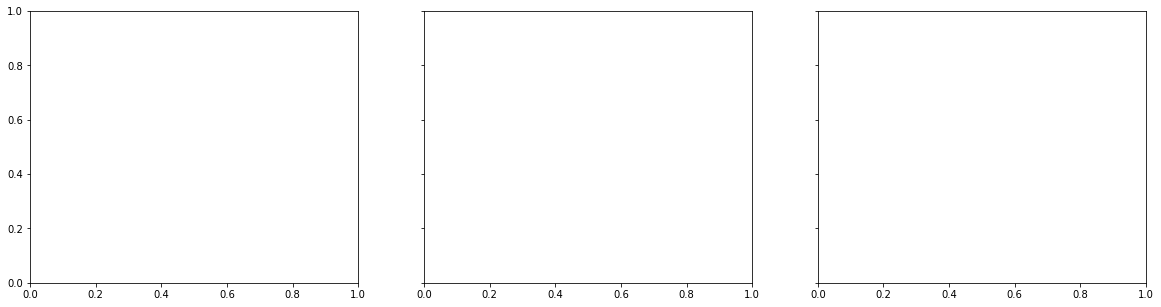

In [20]:
easy_cfgs = [
    {
        "exp" : 'noiseless_easy',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noiseless"
    },
    {
        "exp" : 'noisy_easy',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noisy"
    },
    {
        "exp" : 'noisy_easy_constrained',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noisy\nRestricted Jumps"
    }
]
diff_cfgs = [
    {
        "exp" : 'noiseless_hard',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noiseless"
    },
    {
        "exp" : 'noisy_hard',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noisy"
    },
    {
        "exp" : 'noisy_hard_constrained',
        "output_path" : 'tmp/fig10.tiff',
        "title" : "Noisy\nRestricted Jumps"
    }
]

def plot_subplots(cfgs, suptitle, output_path):
    f, axes = plt.subplots(1, len(cfgs), figsize=(20, 5), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, plotcfg in enumerate(cfgs):
        exp = plotcfg['exp']
        title = plotcfg['title']

        with open("exp_cfgs/%s.json" % exp, 'r') as f:
            exp_cfg = json.load(f)

        min_ron = exp_cfg['min_ron']
        min_yield = exp_cfg['min_yield']
        models = ['random', 'greedy', 'eg', 'pi', 'ei']
        names = ['Random', 'Greedy', '$\epsilon$-greedy', 'PI', 'EI']

        paths = [(m, "traces/%s_%s.json" % (exp, m), n) for m,n in zip(models, names)]

        # we have to take into account the expected value of the min yield 
        # in noisy experiments. Since the noise is added symmetricly around those thresholds this is usually the
        # same as the threshold itself. But for example when yield is 99 and delta is 2.5, the 
        # expected value is 98.25, which makes a huge difference.
        if exp_cfg['yield_delta'] > 0:
            yield_upper = np.minimum(100, min_yield + exp_cfg['yield_delta'])
            yield_lower = min_yield - exp_cfg['yield_delta']
            #min_yield = (yield_upper + yield_lower) / 2
            print("Effective min yield: %0.2f" % min_yield)

        # if exp_cfg['ron_delta'] > 0:
        #     ron_upper = np.maximum(100, min_ron + exp_cfg['ron_delta'])
        #     ron_lower = min_yield - exp_cfg['yield_delta']
        #     min_yield = (yield_upper + yield_lower) / 2

        valid_comb_ix =(df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)

        ax = axes[i]
        for _,p,name in paths:
            #print(p)
            with open(p, 'r') as f:
                results = json.load(f)

            trace_chs = []
            for obs_traces, traces in zip(results['obs_traces'], results['traces']):
                true_traces = Y[traces, :]
                obs_traces = np.array(obs_traces)

                fix = (true_traces[:,1] >= min_ron) & (true_traces[:,2] >= min_yield)
                obs_traces[~fix,0] = np.inf
                trace_chs.append(np.minimum.accumulate(obs_traces[:,0]))

            #inputs = df.iloc[results['traces'][0]]
            #print(inputs.iloc[10:])
            trace_chs = np.array(trace_chs) / (1000*1000)
            print(trace_chs.shape)
            trace_chs[np.isinf(trace_chs)] = np.nan
            reps = np.sum(~np.isnan(trace_chs), axis=0)

            mean_trace = np.nanmean(trace_chs, axis=0)
            stderr_trace = np.nanstd(trace_chs, axis=0, ddof=1) / np.sqrt(reps)

            ax.errorbar(np.arange(mean_trace.shape[0]), mean_trace, yerr=stderr_trace, linewidth=5, label=name, marker='o', markersize=2, elinewidth=2)
            #ax.plot(, )

        ax.plot(np.arange(mean_trace.shape[0]), np.ones(mean_trace.shape[0]) * 
                np.min(df[valid_comb_ix]['r1_charge_heater'] / (1000*1000)), linewidth=5, linestyle='--', label='True Min')
        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)

        ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')

        if i ==0:
            ax.set_ylabel('Minimum Feasible \nCharge Heater (GJ/h)', fontsize=28, fontweight='bold')
            ax.legend(fontsize=24, frameon=False, ncol=6, bbox_to_anchor=(3.35, -0.20))
        
        ax.grid(True)
        ax.set_title(title, fontsize=32, fontweight='bold', pad=20)

        ax.set_xlim([0,100])

    plt.suptitle(suptitle, fontsize=42, fontweight='bold', y=1.25)
    plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

plot_subplots(easy_cfgs, 'Active Experimentation - Easy Constraints', 'tmp/fig10.tiff')
plot_subplots(diff_cfgs, 'Active Experimentation - Difficult Constraints', 'tmp/fig11.tiff')
